# VSA Recall Datatypes

- A part of the important characteristics of hypervectors (HV) is it's ability to recall objects from a stack of bundled elements.
- Here we will compare which among the item memories gives the best recall capabilities.
- We will measure the recall as how much is the distance of one of the bundled elements with all the bundled set.

In [1]:
# Import library
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm

# Gets directory where script was launched from
script_dir = os.getcwd()  
script_dir = script_dir + "/../lib/"
print(f"VSA Library: {script_dir}")

# Add the directory to Python's search path
sys.path.append(script_dir)  

import vsa as vsa
import vsa_func as vsaf
import vsa_profile as vsap

VSA Library: \\wsl.localhost\Ubuntu\home\rantonio\chronomatica\vsa/../lib/


In [2]:
# Parameters to modify
HV_DIM = 1000
# Use odd number NUM_ITEMS to avoid ties when bundling
NUM_ITEMS = 501
THRESHOLD = NUM_ITEMS / 2
NUM_TRIALS = 1000
HV_DIM_LIST = [1024, 2048, 4096, 8192]

- We will also add some basics, in terms of law of large numbers of a Bernoulli variable, where each element is in the range of $[0,1]$ and some dimension $D$, then fundamentally it leads to:

$$ \mu = \frac{D}{2} $$
$$ \sigma^2 = \frac{D}{4}$$
$$ \sigma = \frac{\sqrt{D}}{2}$$

- So for instance, when $D = 1,000$ then $\mu = 500$ and $\sigma^2 = 250 \rightarrow \sigma= \pm 15.811$ and the $3\sigma = 47.43$ rule tells us that $99.7\%$ of the distribution would contain such patterns.
- You can revisit this from [VSA Similarity Fundamentals](https://github.com/rgantonio/chronomatica/blob/main/vsa/vsa_sim_fundamentals.ipynb)
- The code below shows the table


In [3]:
def expected_mean_std_var(D):
    mu = D / 2
    var = D / 4
    std = np.sqrt(var)
    return mu, std, var

print("D\tmu\tvar\tstd\tsigma3")
for d in HV_DIM_LIST:
    mu, std, var = expected_mean_std_var(d)
    sigma3 = 3 * std
    print(f"{d}\t{mu:.2f}\t{var:.2f}\t{std:.2f}\t{sigma3:.2f}")

D	mu	var	std	sigma3
1024	512.00	256.00	16.00	48.00
2048	1024.00	512.00	22.63	67.88
4096	2048.00	1024.00	32.00	96.00
8192	4096.00	2048.00	45.25	135.76


- From here, the goal is simple, we need to analyze how the noise affects a single element of a bundle such that its similarity is strong enough to overcome the bounds of the standard deviation.
- In other words, whenever we do a bundling operation and probe one of the existing elements, should be beyond the $3 \sigma$ of the distribution.
- One can always test a simple case with small number of bundled elements, that the similarity of a single element is definitely out of bounds of the $3 \sigma$ distribution.
- This is what makes it unique for all. **However, in this experiment we want to see if the data types (binary, bipolar, integer, and real) affect this expected distance**
- First we generate the range of bundled elements but make sure to do it in steps of 3 to avoid adding extra randomization element that breaks ties for elements which cannot be decided if they are 1s or 0s.

In [4]:
x = np.arange(3, NUM_ITEMS+1, 2)

- Make a function for measuring bundle scores but averaged through `num_trials` with `num_items` per bundle. Of course the `hv_dim` sets the HV size and `im_type` selects between the available types.
- For `integer` based, set the minimum and maximum to be in the range $[-128,127]$.
- Then use hamming distance only for `binary` data types while the others will use cosine similarity.

In [5]:
def im_bundle_scores(num_trials, num_items, hv_dim, disable_tqdm=False, im_type="binary", int_min=-128, int_max=127):
    # Just re-do this for the sake of making elements
    x = np.arange(3, num_items+1, 2)
    score_matrix  = np.zeros((num_trials, len(x)))
    # Iterate through different trial so we average thme out later
    for trial in tqdm.tqdm(range(num_trials), desc="Trials", disable=disable_tqdm):
        if (im_type == "integer"):
            im = vsaf.gen_orthogonal_im(num_items, hv_dim, type=im_type, int_min=-128, int_max=127)
        else:
            im = vsaf.gen_orthogonal_im(num_items, hv_dim, type=im_type)

        # Iterate through different bundle sizes
        for i, bundle_num in enumerate(x):
            if im_type =="binary":
                threshold = bundle_num / 2
                bundled_im = vsa.hv_add(im[0:bundle_num], threshold=threshold)
                score_matrix[trial, i] = vsa.hv_ham(im[0], bundled_im)
            else:
                bundled_im = vsa.hv_add(im[0:bundle_num], sign_magnitude=True, threshold=None)
                score_matrix[trial, i] = vsa.hv_cos(im[0], bundled_im)
    return score_matrix


In [6]:
def calculate_mean_std(score_matrix):
    mean_vec = np.mean(score_matrix, axis=0)
    std_vec = np.std(score_matrix, axis=0)
    return mean_vec, std_vec

In [7]:
def plot_single_with_error_bars(hv_dim, x, mean_vec, std_vec, func_mean_var, xytext_offset=(5,10)):
    # Get the ideal curve
    mu, std, _ = func_mean_var(hv_dim)
    # Create a line for the mean and sim cut score
    mu_line = np.array([mu/hv_dim] * len(x))
    std_line = np.array([3*std/hv_dim] * len(x))
    # Plot ideal mean and std lines
    plt.plot(x, mu_line, color='green', label=f"Theoretical $\mu$ = {mu/hv_dim:.3f}" )
    plt.fill_between(x, mu_line - std_line, mu_line + std_line, alpha=0.2, color='green', label=f"Theoretical $3\sigma$ = {3*std/hv_dim:.3f}" )

    # Get cut for the score
    sim_cut_score = np.array([(mu + 3*std) / hv_dim] * len(x))
    # Highlight point of intersection between the sim_cut_score and mean_vec
    intersection_index = np.where((mean_vec - 3*std_vec) >= sim_cut_score)[0][-1]
    # Plot point of intersection only
    plt.plot(x[intersection_index], (mean_vec - 3*std_vec)[intersection_index], 'o', color='blue')
    sim_cut_actual_score = [(mean_vec - 3*std_vec)[intersection_index]]*len(x)
    plt.plot(x, sim_cut_actual_score, linestyle='--', color='gray')
    plt.axvline(x[intersection_index], linestyle='--', color='gray')

    # Plot the mean with error bars
    plt.plot( x, mean_vec, linewidth=2,  color="red", label=f"Empirical $\mu$ = {mean_vec[intersection_index]:.3f}" )
    plt.fill_between( x, mean_vec - 3*std_vec, mean_vec + 3*std_vec, alpha=0.4, label=f"Empirical $3\sigma$ = {3*std_vec[intersection_index]:.3f}" )

    # Add text within plot pointing to the x,y coordinates of the intersection point
    plt.annotate(
        f"({x[intersection_index]}, {(mean_vec - 3*std_vec)[intersection_index]:.3f})",
        xy=(x[intersection_index], (mean_vec - 3*std_vec)[intersection_index]),
        xytext=xytext_offset,  # offset in points (x, y)
        textcoords="offset points",
        fontsize=12,
        ha="left",
        va="bottom"
    )
    plt.ylim(0.4,0.7)
    # Add labels and title
    plt.xlabel("Bundle Size")
    plt.ylabel("Sim Score")
    plt.legend()
    plt.show()

- We also make some other useful functions:
  - `calculate_mean_std`: to calculate the mean and std. dev on the the scores
  - `plot_with_error_bars`: to plot the trend with error bars appended to it.
- Then first we check the patterns for the binary data type

In [8]:
binary_score = im_bundle_scores(NUM_TRIALS, NUM_ITEMS, HV_DIM, im_type="binary")

Trials:   0%|          | 2/1000 [00:00<01:17, 12.88it/s]

Trials: 100%|██████████| 1000/1000 [01:10<00:00, 14.28it/s]


In [9]:
binary_mean_vec, binary_std_vec = calculate_mean_std(binary_score)
# Since hamming distance is amount of difference
# We subtract from 100% to get similarity instead
binary_mean_vec = 1 - binary_mean_vec

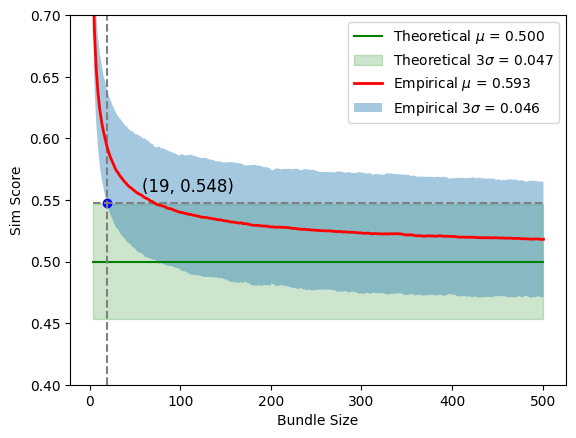

In [10]:
plot_single_with_error_bars(1024, x, 
                     binary_mean_vec, binary_std_vec, expected_mean_std_var,
                     xytext_offset=(25,5))

- Here we first analyze and understand the implications of the plot. The red line shows how the sim score changes as we add more and more elements into the bundle. The more we add, the similarity of a single element to the bundle is strong but trails of very quickly.
- In fact the safest we can do is when we are above $3\sigma$ of the expected mean. For example, with the current $D=1000$, the $\mu=500$ and the $3\sigma = 47.43$. Therefore, if the similarity is above $500 + 47.43 = 547.43$ Hamming distance, then we are sure that the element is still distinguishable from the *pseudo-orthogonality* spectrum.
- In the above case a bundled element size of 37 is most ideal assuming all bundled elements are distinct from one another for the $D=1000$ case. If we go within the bounds of the $3\sigma$ then there is a slight chance we are part of the the *pseudo-orthogonal* spectrum.
- We can further observe how the curve first changes when we increase $D$

In [11]:
binary_mean_trend = {}
binary_stddev_trend = {}
for i in tqdm.tqdm(range(len(HV_DIM_LIST)), desc="Dimension"):
    binary_score_D = im_bundle_scores(NUM_TRIALS, NUM_ITEMS, HV_DIM_LIST[i], disable_tqdm=True,im_type="binary")
    binary_mean_trend[HV_DIM_LIST[i]], binary_stddev_trend[HV_DIM_LIST[i]] = calculate_mean_std(binary_score_D)


Dimension: 100%|██████████| 4/4 [15:32<00:00, 233.11s/it]


In [12]:
# This is for inverting hamming distance
# to get similarity score rather than dissimilarity
for D in HV_DIM_LIST:
    binary_mean_trend[D] = 1 - binary_mean_trend[D]

In [13]:
def plot_dimension_change(x, hv_dim_list, mean_trend, stddev_trend, func_mean_var, subplot_shape, xytext_offset=(5,10), set_ylim=(0.5,0.6), im_type="binary"):

    # Some base variables and settings
    alpha = 0.4
    row_idx = 0
    col_idx = 0
    max_rows, max_cols = subplot_shape

    # Set figure size
    fig, axes = plt.subplots(max_rows, max_cols, figsize=(10, 10), dpi=100)

    for i, D in enumerate(hv_dim_list):
        row_idx = i // max_cols
        col_idx = i % max_cols

        mu, std, _ = func_mean_var(D)

        # Create a line for the mean and sim cut score
        if im_type == "binary":
            mu_line = np.array([mu/D] * len(x))
            std_line = np.array([3*std/D] * len(x))
        else:
            mu_line = np.array([mu] * len(x))
            std_line = np.array([3*std] * len(x))

        # Plot ideal mean and std lines
        if im_type == "binary":
            axes[row_idx, col_idx].plot(x, mu_line, color='green', label=f"Theoretical $\mu$ = {mu/D:.3f}" )
            axes[row_idx, col_idx].fill_between(x, mu_line - std_line, mu_line + std_line, alpha=0.2, color='green', label=f"Theoretical $3\sigma$ = {3*std/D:.3f}" )
        else:
            axes[row_idx, col_idx].plot(x, mu_line, color='green', label=f"Theoretical $\mu$ = {mu:.3f}" )
            axes[row_idx, col_idx].fill_between(x, mu_line - std_line, mu_line + std_line, alpha=0.2, color='green', label=f"Theoretical $3\sigma$ = {3*std:.3f}" )


        # Get cut for the score
        if im_type == "binary":
            sim_cut_score = np.array([(mu + 3*std) / D] * len(x))
        else:
            sim_cut_score = np.array([(mu + 3*std)] * len(x))

        # Highlight point of intersection between the sim_cut_score and mean_vec
        intersection_index = np.where((mean_trend[D] - 3*stddev_trend[D]) >= sim_cut_score)[0][-1]
        # Plot point of intersection only
        axes[row_idx, col_idx].plot(x[intersection_index], (mean_trend[D] - 3*stddev_trend[D])[intersection_index], 'o', color='blue')
        # Plot cross line
        sim_cut_actual_score = [(mean_trend[D] - 3*stddev_trend[D])[intersection_index]]*len(x)
        axes[row_idx, col_idx].plot(x, sim_cut_actual_score, linestyle='--', color='gray', label=f"y={sim_cut_actual_score[0]:.3f}" )
        axes[row_idx, col_idx].axvline(x[intersection_index], linestyle='--', color='gray')

        axes[row_idx, col_idx].annotate(
            f"({x[intersection_index]}, {mean_trend[D][intersection_index]:.3f})",
            xy=(x[intersection_index], (mean_trend[D] - stddev_trend[D])[intersection_index]),
            xytext=xytext_offset,  # offset in points (x, y)
            textcoords="offset points",
            fontsize=12,
            ha="left",
            va="bottom"
        )

        # Plot the points
        axes[row_idx, col_idx].plot( x, mean_trend[1024], 
                        linewidth=2, color="red")
        axes[row_idx, col_idx].fill_between( 
            x, 
            mean_trend[D] - 3*stddev_trend[D], 
            mean_trend[D] + 3*stddev_trend[D], 
            alpha=alpha,
            label=f"$3\sigma$ = {3*stddev_trend[D][-1]:.4f}"
        )
        axes[row_idx, col_idx].set_title(f"D={D}")
        axes[row_idx, col_idx].set_ylim(set_ylim)
        axes[row_idx, col_idx].legend()

    # Add labels and title
    plt.xlabel("Bundle Size")
    plt.ylabel("Sim Score")
    plt.show()



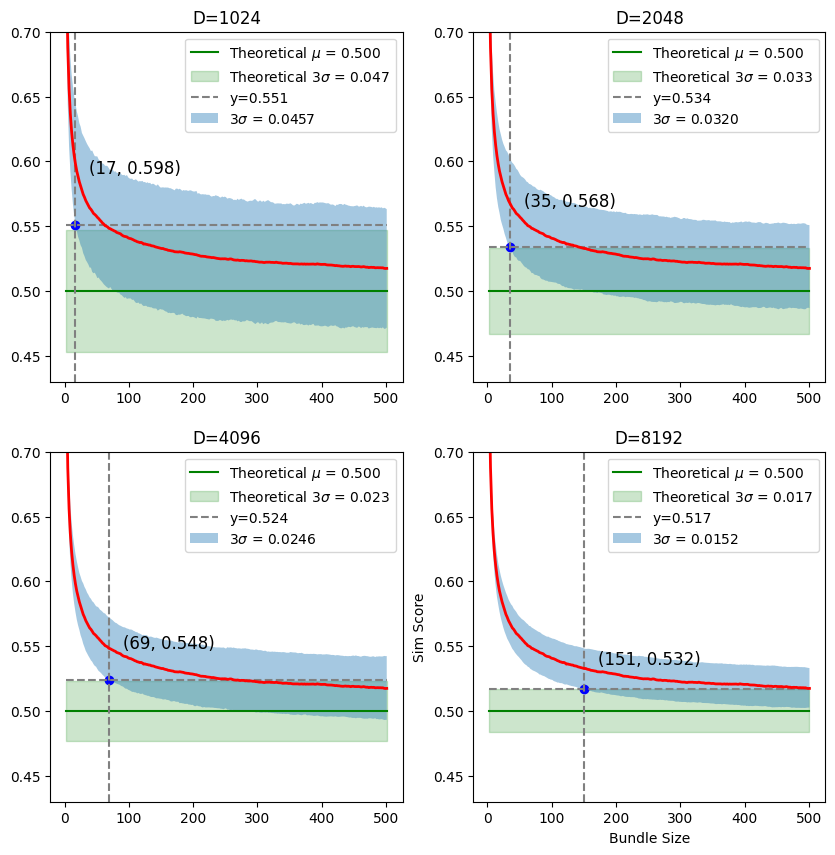

In [14]:
plot_dimension_change(
    x, 
    HV_DIM_LIST,
    binary_mean_trend, 
    binary_stddev_trend, 
    expected_mean_std_var, 
    subplot_shape=(2,2), 
    xytext_offset=(10,5),
    set_ylim=(0.43,0.7),
)

## Sub-conclusion for Binary Datatypes
- The code above is the main function for checking how the trend changes with dimension change.
- It plots:
  - How the noise increases (visually decreasing similarity score) with increasing bundle size
  - The variance decreases as the dimension increases.
  - The number of acceptable bundle size increases linearly with increasing dimension.
- We have to take note that the HVs bundled are all distinct from one another, hence this assumes almost a worst corner case.
- The main conclusion is that (consistent with the math) the mean never changes, they are quite the same but the effective variance decreases with increasing dimension. Consequently, the total number of safe elements to bundle increases linearly with dimension too.

## Non-binary Trends
- This time, we will explore the non-binary data types: `bipolar`, `integer`, and `real`
- The biggest change and consideration is that the similarity score should now be a cosine function.
- Consequently, this affects the estimated mean and variance. The basis should come from [VSA Similarity Fundamentals](./vsa_sim_fundamentals.ipynb)
- We will do the same but we need to make the new expected mean and variance based on the theoretical estimates.

In [15]:
def expected_mean_std_var_non_binary(D):
    mu = 0
    var = 1/D
    std = np.sqrt(var)
    return mu, std, var

print("D\tmu\tvar\tstd\tsigma3")
for D in HV_DIM_LIST:
    mu, std, var = expected_mean_std_var_non_binary(D)
    sigma3 = 3 * std
    print(f"{D}\t{mu:.5f}\t{var:.5f}\t{std:.5f}\t{sigma3:.5f}")

D	mu	var	std	sigma3
1024	0.00000	0.00098	0.03125	0.09375
2048	0.00000	0.00049	0.02210	0.06629
4096	0.00000	0.00024	0.01562	0.04688
8192	0.00000	0.00012	0.01105	0.03315


In [16]:
bipolar_mean_trend = {}
bipolar_stddev_trend = {}
for i in tqdm.tqdm(range(len(HV_DIM_LIST)), desc="Dimension"):
    bipolar_score_D = im_bundle_scores(NUM_TRIALS, NUM_ITEMS, HV_DIM_LIST[i], disable_tqdm=True,im_type="bipolar")
    bipolar_mean_trend[HV_DIM_LIST[i]], bipolar_stddev_trend[HV_DIM_LIST[i]] = calculate_mean_std(bipolar_score_D)


Dimension: 100%|██████████| 4/4 [15:23<00:00, 230.96s/it]


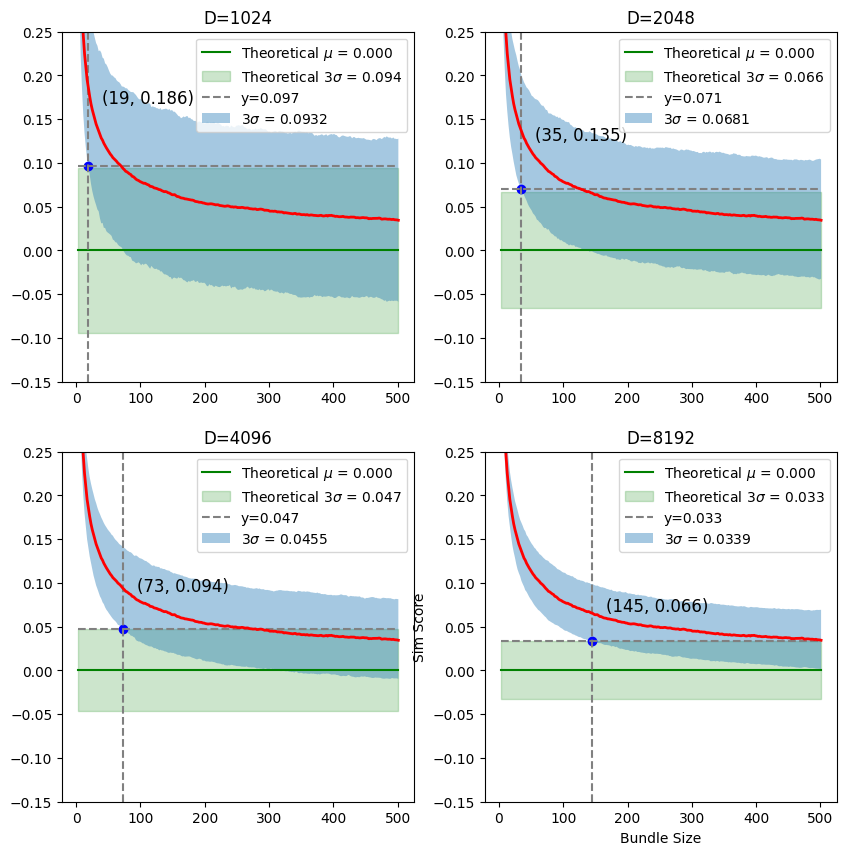

In [17]:
plot_dimension_change(
    x, 
    HV_DIM_LIST,
    bipolar_mean_trend, 
    bipolar_stddev_trend, 
    expected_mean_std_var_non_binary, 
    subplot_shape=(2,2), 
    xytext_offset=(10,5),
    set_ylim=(-0.15,0.25),
    im_type="bipolar"
)

## Sub-conclusion for Bipolar Datatypes
- At this point, the variance is consistent with the theoretical estimates from [VSA Sim Fundamentals](./vsa_sim_fundamentals.ipynb)
- Interestingly that the measures are quite close to the Hamming distance but the lower the dimension, the better it is for Hamming but the higher the dimension the better it is for the cosine similarity.
- We try below the cases for integer and real. Take note that they use the same expected mean and std. dev.

In [18]:
integer_mean_trend = {}
integer_stddev_trend = {}
for i in tqdm.tqdm(range(len(HV_DIM_LIST)), desc="Dimension"):
    integer_score_D = im_bundle_scores(NUM_TRIALS, NUM_ITEMS, HV_DIM_LIST[i], disable_tqdm=True,im_type="integer")
    integer_mean_trend[HV_DIM_LIST[i]], integer_stddev_trend[HV_DIM_LIST[i]] = calculate_mean_std(integer_score_D)


Dimension: 100%|██████████| 4/4 [11:30<00:00, 172.52s/it]


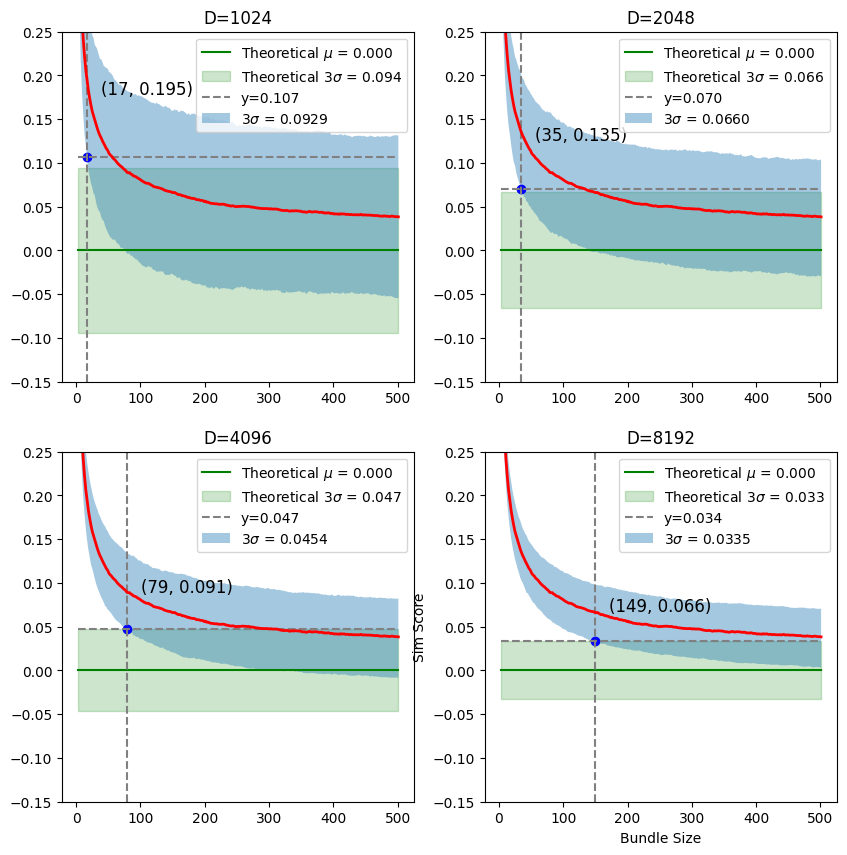

In [19]:
plot_dimension_change(
    x, 
    HV_DIM_LIST,
    integer_mean_trend, 
    integer_stddev_trend, 
    expected_mean_std_var_non_binary, 
    subplot_shape=(2,2), 
    xytext_offset=(10,5),
    set_ylim=(-0.15,0.25),
    im_type="integer"
)

In [20]:
real_mean_trend = {}
real_stddev_trend = {}
for i in tqdm.tqdm(range(len(HV_DIM_LIST)), desc="Dimension"):
    real_score_D = im_bundle_scores(NUM_TRIALS, NUM_ITEMS, HV_DIM_LIST[i], disable_tqdm=True,im_type="real")
    real_mean_trend[HV_DIM_LIST[i]], real_stddev_trend[HV_DIM_LIST[i]] = calculate_mean_std(real_score_D)

Dimension: 100%|██████████| 4/4 [11:27<00:00, 171.92s/it]


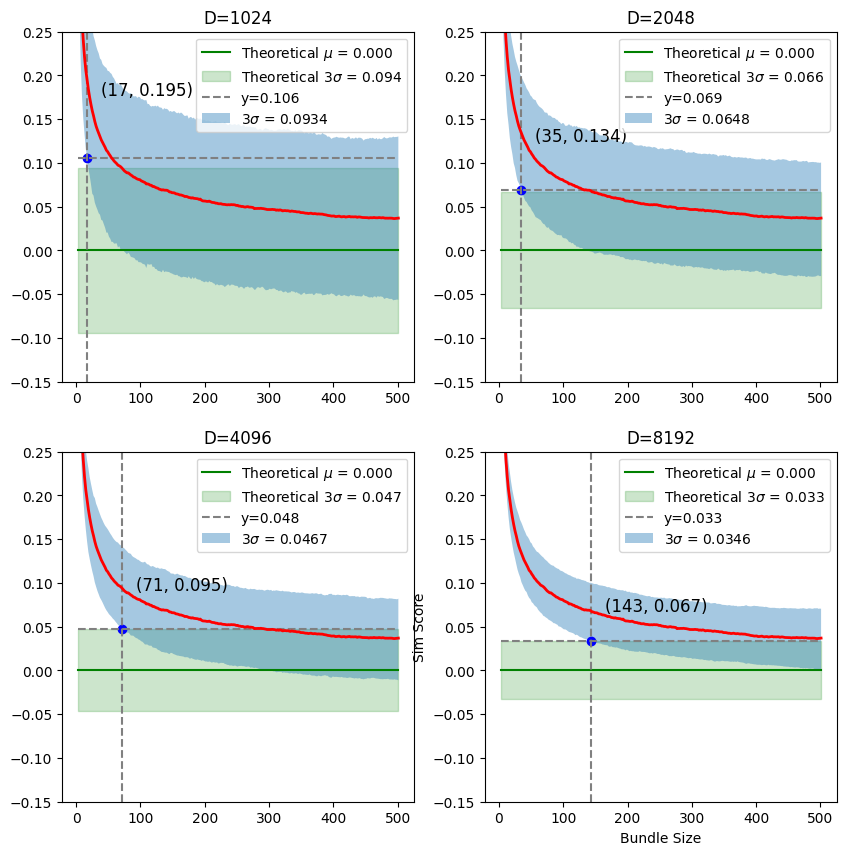

In [21]:
plot_dimension_change(
    x, 
    HV_DIM_LIST,
    real_mean_trend, 
    real_stddev_trend, 
    expected_mean_std_var_non_binary, 
    subplot_shape=(2,2), 
    xytext_offset=(10,5),
    set_ylim=(-0.15,0.25),
    im_type="real"
)

## Sub-conclusion for Others
- For all versions, the number of difference in bundled elements is insignificant (i.e., < 10 element differences).
- Regardless if it's a cosine similarity or Hamming distance, the number of elements are relatively the same.
- A more interesting trend is that the dimension and number of bundled elements are quite linear with each other. Therefore, linearly packing more information mean linearly increasing the dimension size.
- A bit of thinking is required as for dimension size of $D=1024$ is quite large already but the assumed number of packed elements is very small $<17$ elements. That is not good enough.
- But take note, in several applications, this is heavily influenced by the number of common elements in between. This highly affects the amount of similarity as more common elements start to dominate the representations shifting the similarity much higher.